In [1]:
import xarray as xr
import xarray.ufuncs as xrf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from scipy import stats

In [2]:
alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/'
station = 'Dav'
file = 'Meteor_radar_Dav_GW_201912.h5'
xr.open_dataset( f'{root_path}{station}/{file}', group='info')#['day']
#xr.open_dataset( '/home/gemeinsam_tmp/UA_students/data/Col/Meteor_radar_Col_GW_201903.h5', group='info')['day']

<xarray.Dataset>
Dimensions:  (phony_dim_0: 744, phony_dim_1: 1, phony_dim_2: 26, phony_dim_3: 1)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2, phony_dim_3
Data variables:
    DOY      (phony_dim_0, phony_dim_1) float64 ...
    alt      (phony_dim_1, phony_dim_2) float64 ...
    day      (phony_dim_0, phony_dim_1) float64 ...
    dh_av    (phony_dim_1, phony_dim_3) float64 ...
    dt       (phony_dim_1, phony_dim_3) float64 ...
    dt_av    (phony_dim_1, phony_dim_3) float64 ...
    hour     (phony_dim_0, phony_dim_1) float64 ...
    min      (phony_dim_0, phony_dim_1) float64 ...
    month    (phony_dim_0, phony_dim_1) float64 ...
    sec      (phony_dim_0, phony_dim_1) float64 ...
    year     (phony_dim_0, phony_dim_1) float64 ...

# Meteor radars

* Dav        Davis; GW:200501-201912
* Col         Collm (Leipzig); GW:200408-201903
* Rio         RioGrande (SAAMER- Argentina); GW:200802-201912
* Sod        Sodankyla; GW:200810-201912
* Kir          Kiruna (Sweden ? Esrange); GW:199908-201912
* CMA      CMOR (Canada ? CMA (CMOR All) triple frequency data); GW:200201-201812
* SES        Sodankyla ? Esrange merged (assigned either to Esrange or Sodankyla or a virtual center in between); GW:199908-201912


Dav_start = '2005-01-'
Dav_end = '2019-12-'
Col_start = '2004-08-01'
Col_end='2019-03-06'
Rio_start = '2008-02-01'
Rio_end = '2019-12-31'
Sod_start = '2008-10-'
Sod_end = '2019-12-'
Kir_start = '1999-08-'
Kir_end = '2019-12-'
Cma_start = '2002-01-01'
Cma_end = '2018-12-31'
Ses_start = '1999-08-'
Ses_end = '2019-12-'


# FUNCTIONS

### lineare regression

In [3]:
def new_linregress(y):
   
    x = np.arange(y.shape[0])
    mask = ~np.isnan(y)
    #print('y: '+str(y))
    #print('x: '+str(x))
    
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    return np.array([slope, intercept, r_value, p_value, std_err])
    

def new_linregress_masked(y):
   
    x = np.arange(y.shape[0])
    mask = ~np.isnan(y)
    #print('y: '+str(y))
    #print('x: '+str(x))
    
    try:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
    except:
        slope, intercept, r_value, p_value, std_err = np.nan, np.nan, np.nan, np.nan, np.nan
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    return np.array([slope, intercept, r_value, p_value, std_err])
    

def time_reg(var):
        #print('var:'+str(var.values))
        statistics = xr.apply_ufunc(new_linregress, var, 
                       input_core_dims=[['time']],
                       output_core_dims=[["parameter"]],
                       vectorize=True,
                       dask="allowed", 
                       output_dtypes=['float64'],
                       output_sizes={"parameter": 5},
                      )
        return statistics

def time_reg_masked(var):
        #print('var:'+str(var.values))
        statistics = xr.apply_ufunc(new_linregress_masked, var, 
                       input_core_dims=[['time']],
                       output_core_dims=[["parameter"]],
                       vectorize=True,
                       dask="allowed",
                       output_dtypes=['float64'],
                       output_sizes={"parameter": 5},
                      )
        return statistics

def is_mon(month,sta,end):
    return (month >= sta) & (month <= end)

### Variable einlesen

In [4]:
def read_group(gruppe,loc):
    station = loc#ersten Buchstaben bitte bitte groß schreiben
    
    if loc=='Rio':
        timestart = '2008-02-01'
        timeend = '2019-12-31'
    elif loc == 'Col':
        timestart =  '2004-08-01'
        timeend =  '2019-03-06'
    elif loc=='CMA':
        timestart = '2002-01-01'
        timeend = '2018-12-31'    

    elif loc=='Kir':
        timestart = '1999-08-01'
        timeend = '2018-12-31'
        
    elif loc=='Dav':
        timestart = '2005-01-01'
        timeend = '2019-12-31'   
        
        
    infiles = f'{root_path}{station}/Meteor_radar_{station}_GW_*.h5'
    ds = xr.open_mfdataset(infiles, concat_dim = 'phony_dim_6', group = gruppe, combine='nested',parallel = True)
    ds = ds.rename({'phony_dim_6': 'time', 'phony_dim_7': 'alt'})
    #ds=ds.chunk({'alt': 12})
    ds['alt'] = alt
    ds['alt'].attrs['units'] = 'km'
    # change time range according to meteor radar station
    ds['time'] = pd.date_range(start = timestart, end = timeend, periods = ds.time.shape[0]) 
    return ds
    
    

In [5]:
def read_var(gruppe, var):
        varout = gruppe[var]
        return varout

### Horizontal Wind

In [6]:
def hwind(u,v):
    return np.sqrt(u**2+v**2)
    

### time mean

In [7]:
def time_mean(step,var):
    return var.resample(time='1'+step).mean('time') #Immer nur D oder M oder H oder Y eintragen! Mit Anführungszeichen!
    
    

### Amomalies

In [8]:
def anomalie(step,var):
    string = "time."+step   
    climatology = var.groupby(string).mean("time")
    anomalies = var.groupby(string) - climatology
    
    return anomalies




## Radar Measurements

In [9]:
station = 'Rio'
ds_radar= read_group('wind',station)
u_radar = read_var(ds_radar,'u')  
v_radar = read_var(ds_radar,'v')

u_radar_ano = anomalie('day',u_radar)
v_radar_ano = anomalie('day',u_radar)

u_radar_monano = anomalie('month',u_radar)
v_radar_monano = anomalie('month',v_radar)

u_radar_monthly_ano = time_mean('M',u_radar_monano)
v_radar_monthly_ano = time_mean('M',v_radar_monano)

u_radar_monthly = time_mean('M',u_radar)
v_radar_monthly = time_mean('M',v_radar)

u_radar_yearano = anomalie('month',u_radar)
v_radar_yearano = anomalie('month',v_radar)

u_radar_yearly_ano = time_mean('Y',u_radar_yearano)
v_radar_yearly_ano = time_mean('Y',v_radar_yearano)

fig = plt.figure(constrained_layout=True,figsize = [15,9])

windsel=u_radar_monthly_ano.sel(alt = [80,90,100,110], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_radar_monthly_ano.time,windsel)

windsel=v_radar_monthly_ano.sel(alt = [80,90,100,110], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(u_radar_monthly.time,windsel)


### Montsmittel über den gesamten Zeitraum

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


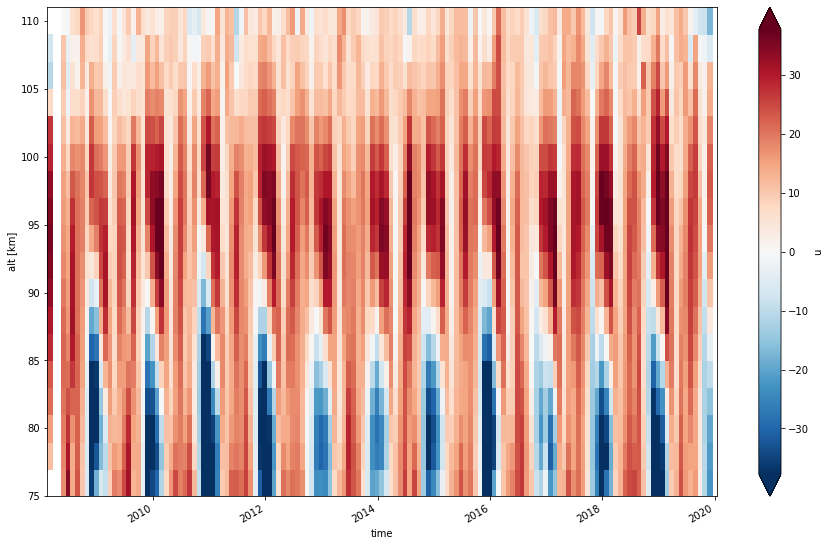

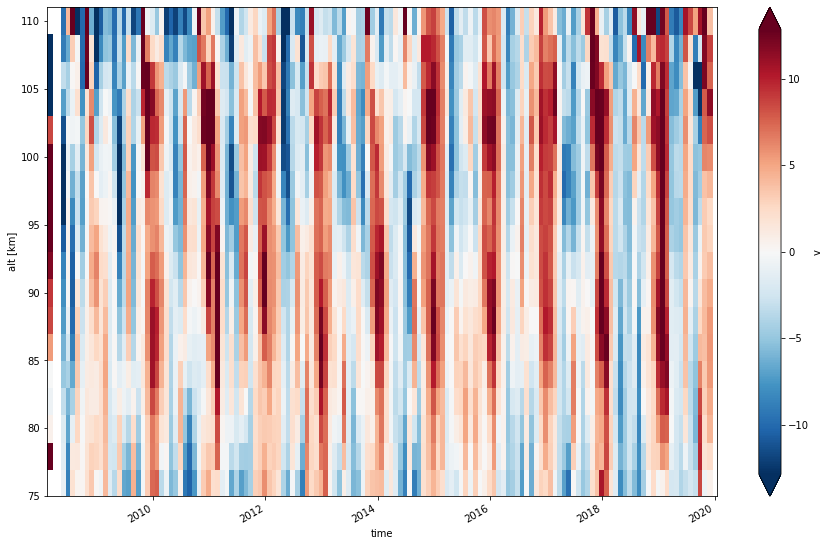

In [10]:
#u_radar_monthly_ano.plot(x = 'time')
u_radar_monthly_slice=u_radar_monthly.sel(alt = slice(75,110))
u_radar_monthly_slice.plot(x='time',robust=True,figsize = [15,9])
v_radar_monthly_slice=v_radar_monthly.sel(alt = slice(75,110))
v_radar_monthly_slice.plot(x='time',robust=True,figsize = [15,9])

Normale Zirkulation:
u: im winter nach osten im sommer nach westen. vorzeichen dreht sich zwischen 90 und 100 km um
v: im in richtung Winter

### look at specific months

In [11]:
#Analyse Months seperatly
s = 3
e = 3
u_radar_examon = u_radar_monthly_ano.sel(time=is_mon(u_radar_monthly_ano['time.month'],s,e))
v_radar_examon = v_radar_monthly_ano.sel(time=is_mon(v_radar_monthly_ano['time.month'],s,e))


xu = np.arange(u_radar_examon.time.shape[0])
u_statistics = time_reg(u_radar_examon)
u_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
xv=np.arange(np.squeeze(v_radar_examon.time.shape))

v_statistics = time_reg(v_radar_examon)
v_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'u' (alt: 1)>
array([nan])
Coordinates:
  * alt        (alt) int64 90
    parameter  <U9 'slope'
<xarray.DataArray 'v' (alt: 1)>
array([nan])
Coordinates:
  * alt        (alt) int64 98
    parameter  <U9 'slope'


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0, 0.5, 'Monthly averaged wind speed')

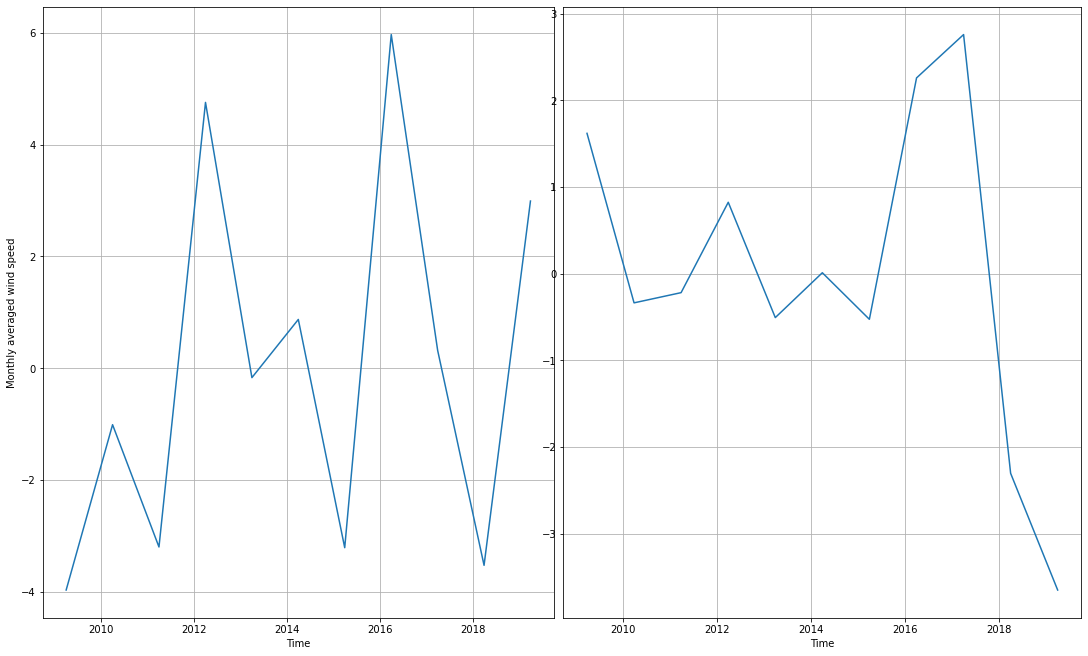

In [12]:
#plot actual DATA

fig = plt.figure(constrained_layout=True,figsize = [15,9])
z = 90
m = (u_statistics.sel(parameter='slope',alt=[z]))
print(m)
n = (u_statistics.sel(parameter='intercept',alt=[z]))
reg = [m*i+n for i in xu]

windsel=u_radar_examon.sel(alt = [z], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_radar_examon.time,windsel)
ax1.plot(u_radar_examon.time,reg)

ax1.grid()

z = 98
m = (v_statistics.sel(parameter='slope',alt=[z]))
print(m)
n = (v_statistics.sel(parameter='intercept',alt=[z]))
reg = [m*i+n for i in xv]
windsel=v_radar_examon.sel(alt = [z], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(v_radar_examon.time,windsel)
ax2.plot(u_radar_examon.time,reg)
ax2.grid()


ax1.set_xlabel('Time')
ax2.set_xlabel('Time')
ax1.set_ylabel('Monthly averaged wind speed')


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

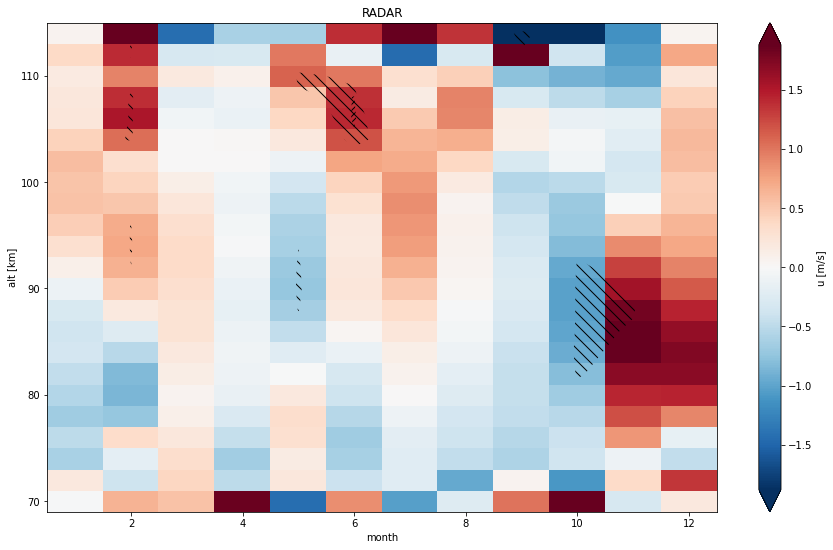

In [13]:
u_statistics = time_reg_masked(u_radar_monthly_ano.groupby('time.month'))
u_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


#u
temp = u_statistics.sel(parameter='slope', alt = slice(70,115)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='month',figsize = [15,9], robust = True)
ax = p.axes
plot_kwargs2 = dict(x ='month',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = u_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('RADAR')
ax.figure.savefig('results/cont_u_radar_'+station+'_mon.png')

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 +

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 +

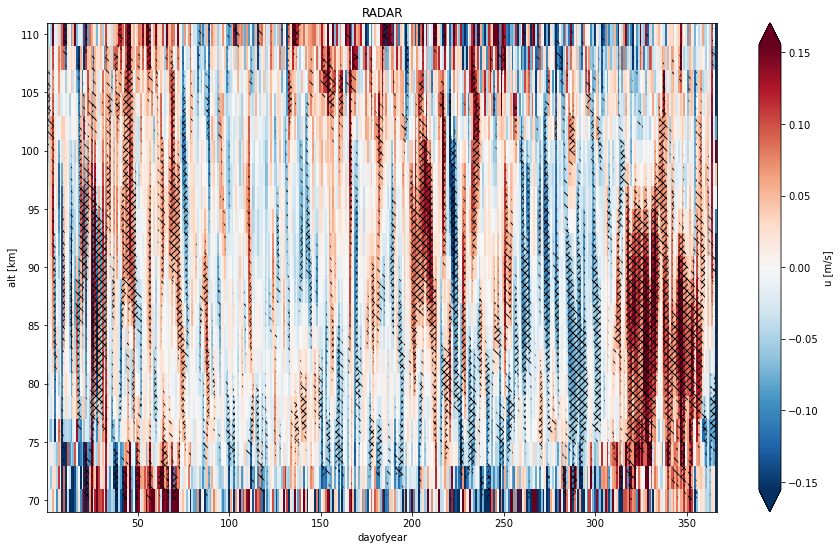

In [14]:
u_statistics = time_reg_masked(u_radar.groupby('time.dayofyear'))

u_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


#u
temp = u_statistics.sel(parameter='slope', alt = slice(70,110)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='dayofyear',figsize = [15,9], robust = True)
ax = p.axes
plot_kwargs2 = dict(x ='dayofyear',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = u_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('RADAR')
ax.figure.savefig('results/cont_u_radar_daily_'+station+'_day.png')

In [15]:
u_statistics


<xarray.DataArray 'u' (dayofyear: 366, alt: 26, parameter: 5)>
array([[[-2.50906206e-02,  4.89165532e+00, -1.41934854e-01,
          2.92255088e-01,  2.35950987e-02],
        [-9.28820617e-03,  5.44935900e+00, -4.09362752e-02,
          7.30946233e-01,  2.69048238e-02],
        [-8.85735320e-03, -7.31294759e-01, -3.54235716e-02,
          7.53554869e-01,  2.81141797e-02],
        ...,
        [-4.08959325e-02,  2.00068380e+01, -1.58999618e-01,
          3.08486055e-01,  3.96580950e-02],
        [-6.79640429e-02,  1.78756286e+01, -2.00831966e-01,
          2.26655029e-01,  5.52529268e-02],
        [-1.73575987e-01,  3.23834212e+01, -4.59746516e-01,
          7.10723204e-03,  6.02182127e-02]],

       [[-1.91564589e-02,  2.22726755e+00, -1.13837306e-01,
          4.21654327e-01,  2.36435798e-02],
        [-1.39790990e-02, -5.46262139e-01, -5.83352691e-02,
          6.28933354e-01,  2.87993852e-02],
        [-2.25065930e-02,  1.00856637e+00, -9.14476212e-02,
          4.44878446e-01,  2.92930612e-02],
        ...,
        [ 1.04423899e-02,  7.63616935e+00,  4.05028141e-02,
          7.84601848e-01,  3.79821262e-02],
        [ 1.32675042e-02,  1.02425849e+01,  5.10678600e-02,
          7.51176500e-01,  4.15472446e-02],
        [ 1.21393613e-02,  8.23967736e+00,  4.08675382e-02,
          8.27210038e-01,  5.51131695e-02]],

       [[-1.13255473e-02,  6.66549333e+00, -4.61069111e-02,
          7.13161770e-01,  3.06719277e-02],
        [-5.77965963e-02,  8.58842696e+00, -1.87822054e-01,
          9.31317424e-02,  3.40050503e-02],
        [ 1.42174436e-02,  8.42210773e-01,  5.07277604e-02,
          6.36852827e-01,  3.00093571e-02],
        ...,
        [-6.61766695e-02,  1.62304893e+01, -2.42177680e-01,
          1.17661930e-01,  4.14051555e-02],
        [-5.74043487e-02,  1.68004887e+01, -2.30808038e-01,
          1.10583713e-01,  3.52985989e-02],
        [ 4.17125474e-02,  6.34025615e+00,  1.38317198e-01,
          4.35323550e-01,  5.27984171e-02]],

       ...,

       [[ 2.86895429e-02,  4.06691682e+00,  9.72943978e-02,
          4.63506994e-01,  3.88716537e-02],
        [ 2.37560072e-02,  6.15174329e-01,  7.94360922e-02,
          4.75319262e-01,  3.31236744e-02],
        [-5.96887804e-02,  1.61154220e-01, -1.71262270e-01,
          8.84366615e-02,  3.46859508e-02],
        ...,
        [-2.62875238e-02,  7.24298818e+00, -6.61788735e-02,
          6.51421009e-01,  5.78133670e-02],
        [ 7.62100367e-02, -1.44015572e+00,  2.13405266e-01,
          1.32679906e-01,  4.98410810e-02],
        [ 1.53571128e-01, -6.99509427e+00,  4.20638438e-01,
          1.47892538e-02,  5.94889619e-02]],

       [[ 2.11434682e-02,  4.76733161e-01,  8.57076307e-02,
          5.49838005e-01,  3.51121715e-02],
        [ 1.87221171e-02, -1.91342250e+00,  7.10098178e-02,
          5.56221926e-01,  3.16602472e-02],
        [-7.70988347e-02,  3.51678226e-01, -2.64115257e-01,
          2.71502786e-02,  3.41427191e-02],
        ...,
        [-1.58727529e-02,  4.07163845e+00, -4.88342935e-02,
          7.47234849e-01,  4.89420934e-02],
        [-4.13578705e-02,  6.18254747e+00, -1.25256415e-01,
          4.66681191e-01,  5.61804050e-02],
        [-1.48321986e-01,  1.30693216e+01, -4.13927536e-01,
          7.13847763e-03,  5.22321792e-02]],

       [[-2.11850562e-01,  1.31902814e+01, -3.74555662e-01,
          2.66350862e-02,  9.12918027e-02],
        [-3.14876334e-01,  1.77515082e+01, -5.35005292e-01,
          1.27817394e-04,  7.49608578e-02],
        [-4.98380088e-01,  1.57893018e+01, -6.81017976e-01,
          5.25394222e-08,  7.73482999e-02],
        ...,
        [-4.12926571e-01,  1.26788239e+01, -4.73474529e-01,
          2.67828218e-03,  1.28028297e-01],
        [-4.47587067e-01,  1.67355116e+01, -3.78399590e-01,
          3.27190024e-02,  1.99898465e-01],
        [-6.90575109e-01,  1.82085489e+01, -4.71382657e-01,
          4.82973995e-02,  3.23006193e-01]]])
Coordinates:
  * alt        (alt) int64 70 72 74 76 78 80 82 ... 108 110 112 114 116 118 1

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

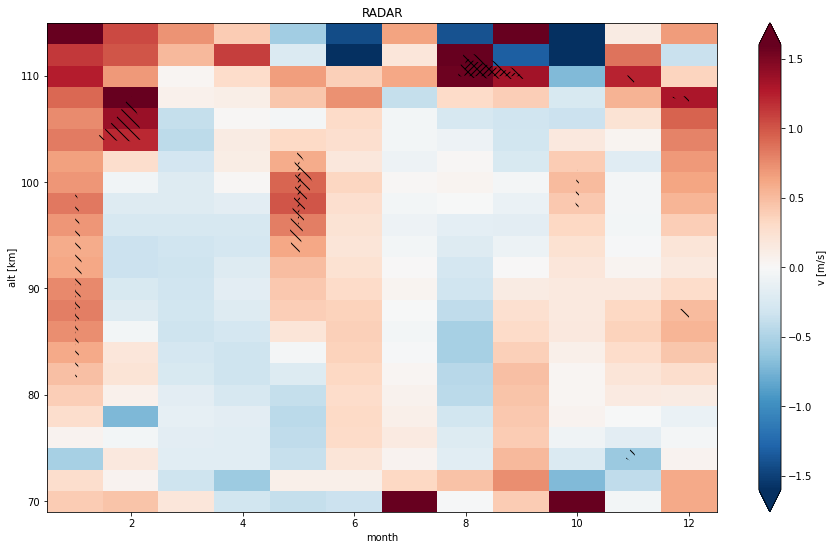

In [16]:
v_statistics = time_reg_masked(v_radar_monthly_ano.groupby('time.month'))
v_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


#u
temp = v_statistics.sel(parameter='slope', alt = slice(70,115)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='month',figsize = [15,9],robust=True)
ax = p.axes
plot_kwargs2 = dict(x ='month',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = v_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('RADAR')
ax.figure.savefig('results/cont_v_radar_'+station+'.png')

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 +

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 +

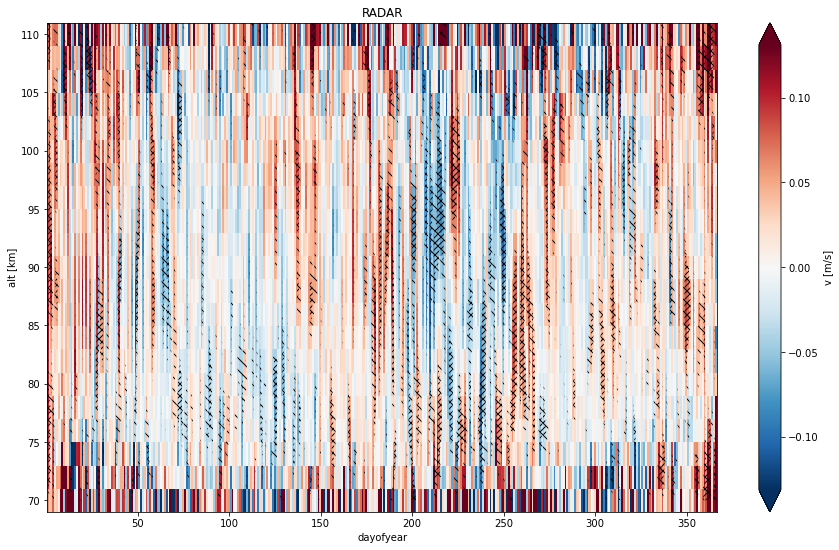

In [17]:
v_statistics = time_reg_masked(v_radar.groupby('time.dayofyear'))
v_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


#u
temp = v_statistics.sel(parameter='slope', alt = slice(70,110)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='dayofyear',figsize = [15,9],robust=True)
ax = p.axes
plot_kwargs2 = dict(x ='dayofyear',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = v_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('RADAR')
ax.figure.savefig('results/cont_v_radar_daily_'+station+'.png')

# GAIA

## Functions for GAIA

In [18]:
root_path = '/home/gemeinsam_tmp/UA_students/data/'
fname = ''

In [19]:
def read_gaia_group(gruppe,loc):
   
    if loc=='Rio':
        timestart = '2008-02-01'
        timeend = '2019-12-31'
        fname = 'GAIA_Rio_20080201_20141231_run20200603.nc'
    
    elif loc == 'Col':
        timestart =  '2004-08-01'
        timeend =  '2017-12-31'
        fname= 'GAIA_Col_20040801_20171231_run20200604.nc'
    
    elif loc=='CMA':
        timestart = '2002-01-01'
        timeend = '2018-12-31'
        fname = 'GAIA_CMA_20020101_20171231_run20200531.nc'
    elif loc=='Kir':
        timestart = '1999-08-01'
        timeend = '2017-12-31'
        fname = 'GAIA_Kir_19990801_20171231_run20200605.nc'    
    elif loc=='Dav':
        timestart = '2005-01-01'
        timeend = '2017-12-31'
        fname = 'GAIA_Dav_20050101_20171231_run20200604.nc'  
    
    infile = f'{root_path}{fname}'
    ds = xr.open_dataset(infile, group=gruppe)
    ds['time'] = pd.date_range(start = timestart, end = timeend, periods=ds.time.shape[0])
    ds = ds.chunk({'alt': 12})
    return ds

## Gaia Simulations

In [20]:
#station = 'Col'
ds = read_gaia_group('GAIA',station)
#print(ds)
u_gaia = ds.u
v_gaia = ds.v

#print('I reach this line...')
u_gaia_monano = anomalie('month',u_gaia)
#print('...And now also this one')
v_gaia_monano = anomalie('month',v_gaia)

u_gaia_monthly_ano = time_mean('M',u_gaia_monano)
v_gaia_monthly_ano = time_mean('M',v_gaia_monano)

u_gaia_monthly = time_mean('M',u_gaia)
v_gaia_monthly = time_mean('M',v_gaia)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


### Contour plots for Gaia

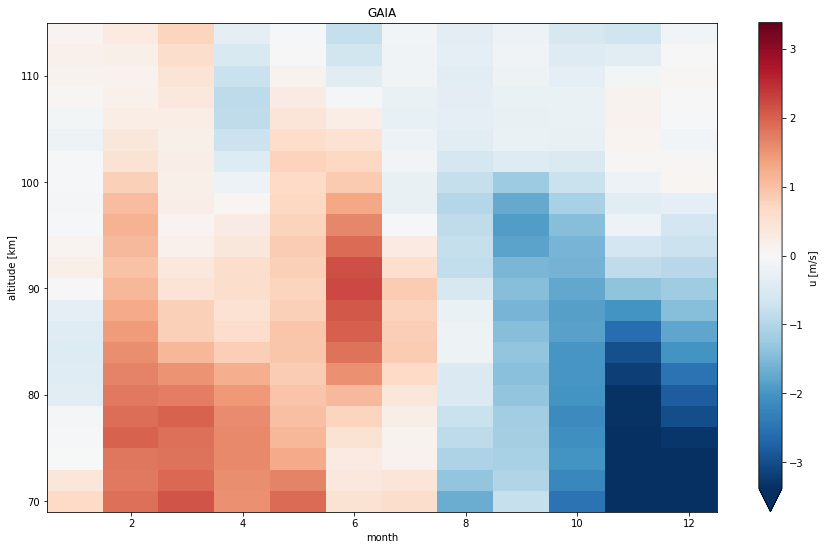

In [21]:
u_statistics = time_reg(u_gaia_monthly_ano.groupby('time.month'))
u_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


#u
temp = u_statistics.sel(parameter='slope', alt = slice(70,115)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='month',figsize = [15,9],robust=True)
ax = p.axes
plot_kwargs2 = dict(x ='month',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = u_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('GAIA')
ax.figure.savefig('results/cont_u_gaia_'+station+'_mon.png')

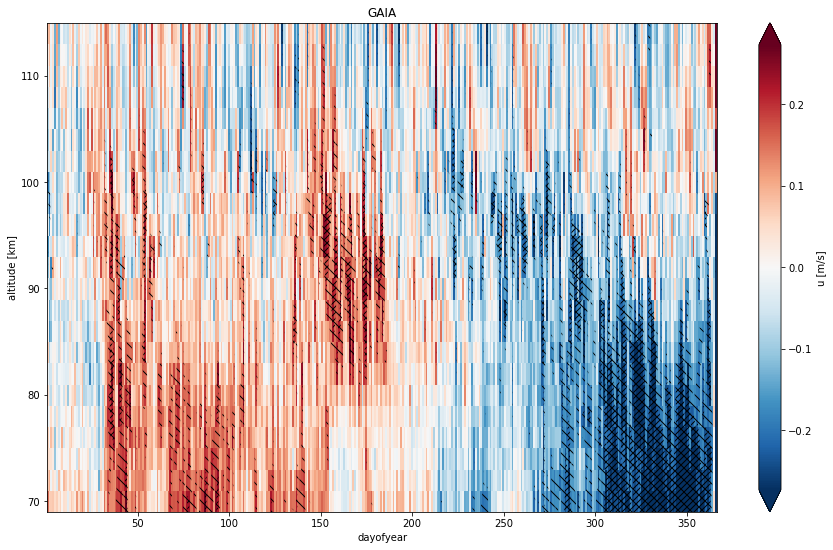

In [22]:
u_statistics = time_reg(u_gaia.groupby('time.dayofyear'))
u_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']


#u
temp = u_statistics.sel(parameter='slope', alt = slice(70,115)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='dayofyear',figsize = [15,9],robust=True)
ax = p.axes
plot_kwargs2 = dict(x ='dayofyear',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = u_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('GAIA')
ax.figure.savefig('results/cont_u_gaia_daily_'+station+'_mon.png')

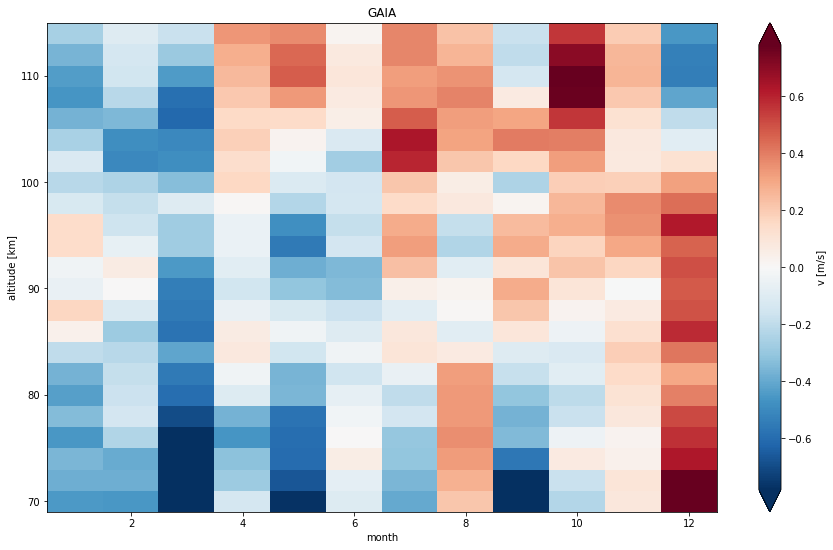

In [23]:
#v
v_statistics = time_reg(v_gaia_monthly_ano.groupby('time.month'))
v_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']

temp = v_statistics.sel(parameter='slope', alt = slice(70,115)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='month',figsize = [15,9],robust=True)
ax = p.axes
plot_kwargs2 = dict(x ='month',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = v_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('GAIA')
ax.figure.savefig('results/cont_gaia_v_'+station+'.png')

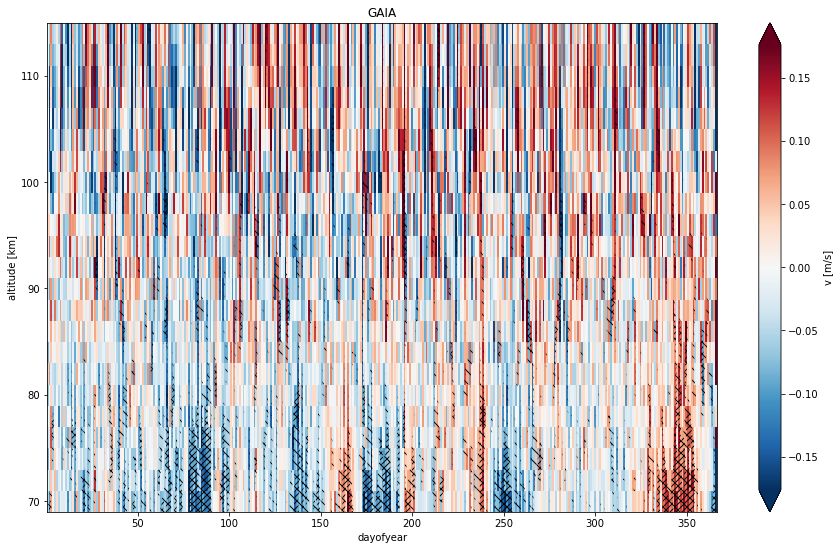

In [24]:
#v
v_statistics = time_reg(v_gaia.groupby('time.dayofyear'))
v_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']

temp = v_statistics.sel(parameter='slope', alt = slice(70,115)) 
temp.attrs['units'] = 'm/s'
p = temp.plot(x='dayofyear',figsize = [15,9],robust=True)
ax = p.axes
plot_kwargs2 = dict(x ='dayofyear',levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv = v_statistics.sel(parameter='p_value')
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title('GAIA')
ax.figure.savefig('results/cont_v_gaia_daily_'+station+'.png')

### Analyzing specific months from GAIA

In [25]:
#Analyse Months seperatly
s = 1
e = 1
u_gaia_examon = u_gaia_monthly_ano.sel(time=is_mon(u_gaia_monthly_ano['time.month'],s,e))
v_gaia_examon = v_gaia_monthly_ano.sel(time=is_mon(v_gaia_monthly_ano['time.month'],s,e))

u_statistics_gaia = time_reg(u_gaia_examon)
u_statistics_gaia['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
xu = np.arange(np.squeeze(u_gaia_examon.time.shape))
v_statistics_gaia = time_reg(v_gaia_examon)
v_statistics_gaia['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
xv = np.arange(np.squeeze(v_gaia_examon.time.shape))




Text(0, 0.5, 'Monthly averaged wind speed')

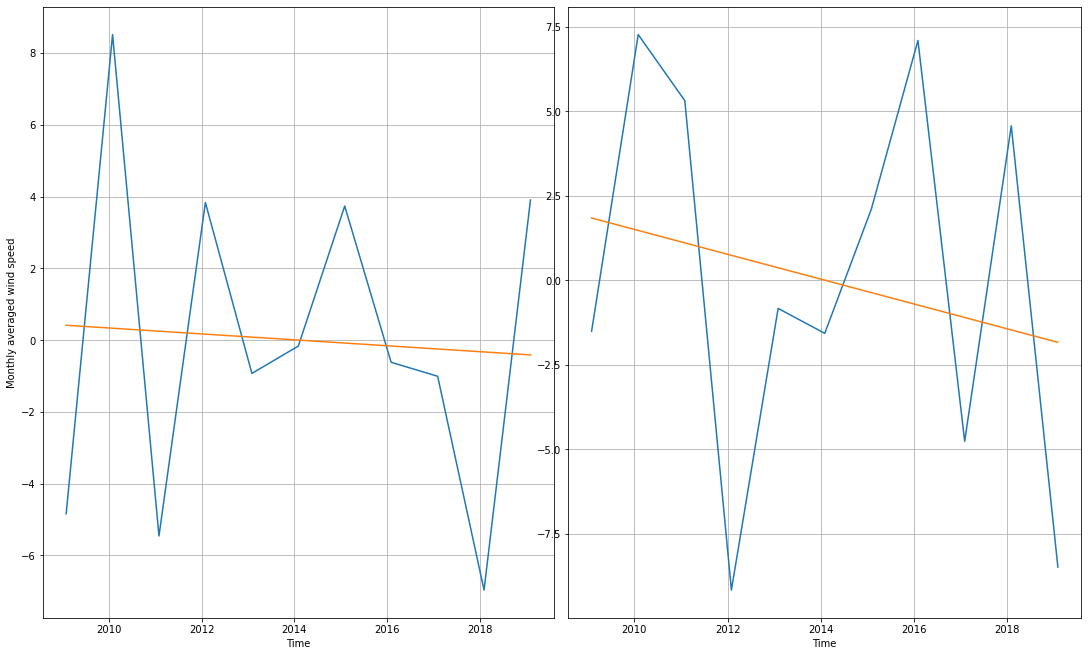

In [26]:
#plot actual DATA
z = 106

fig = plt.figure(constrained_layout=True,figsize = [15,9])
m_gaia = (u_statistics_gaia.sel(parameter='slope',alt=[z]))

n_gaia = (u_statistics_gaia.sel(parameter='intercept',alt=[z]))
reg_gaia = [m_gaia*i+n_gaia for i in xu]

windsel_gaia=u_gaia_examon.sel(alt = [z], method = 'nearest')
ax1 = fig.add_subplot(121)
ax1.plot(u_gaia_examon.time,windsel_gaia)
ax1.plot(u_gaia_examon.time,reg_gaia)

ax1.grid()

z = 106
m_gaia = (v_statistics_gaia.sel(parameter='slope',alt=[z]))

n_gaia = (v_statistics_gaia.sel(parameter='intercept',alt=[z]))
reg_gaia = [m_gaia*i+n_gaia for i in xv]
windsel_gaia=v_gaia_examon.sel(alt = [z], method = 'nearest')
ax2 = fig.add_subplot(122)
ax2.plot(v_gaia_examon.time,windsel_gaia)
ax2.plot(u_gaia_examon.time,reg_gaia)
ax2.grid()

ax1.set_xlabel('Time')
ax2.set_xlabel('Time')
ax1.set_ylabel('Monthly averaged wind speed')


## Plotting Radar + Gaia Measurements

### u

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


P Values: 
Radar   0.244
Gaia    0.632
results/Rio_10_76_u.png
Done with z: 76


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


P Values: 
Radar   0.07
Gaia    0.629
results/Rio_10_80_u.png
Done with z: 80


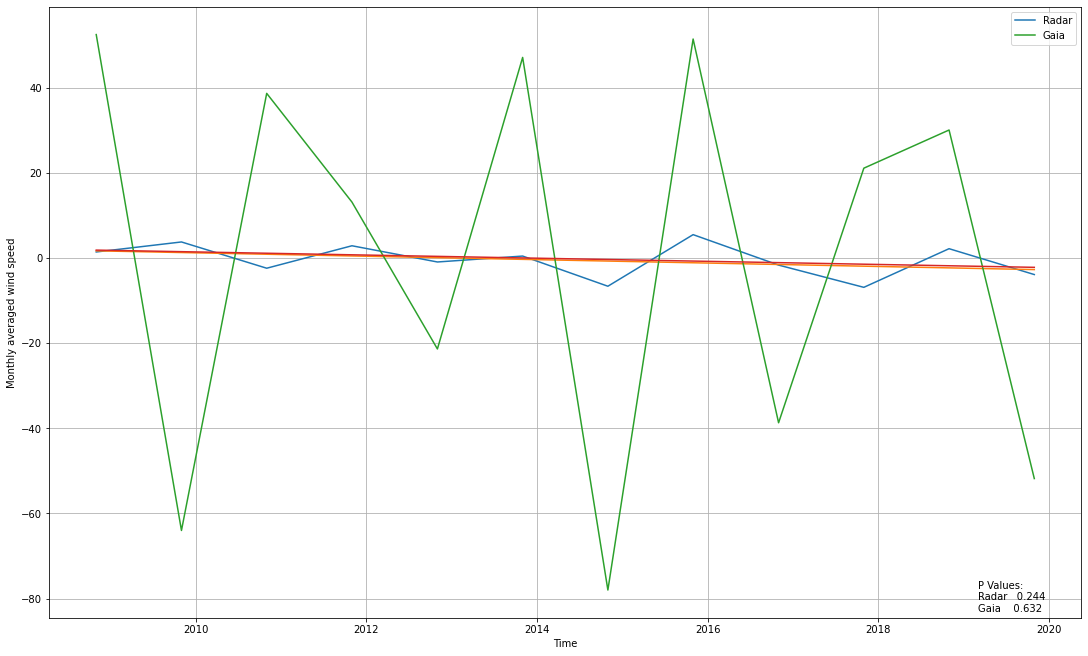

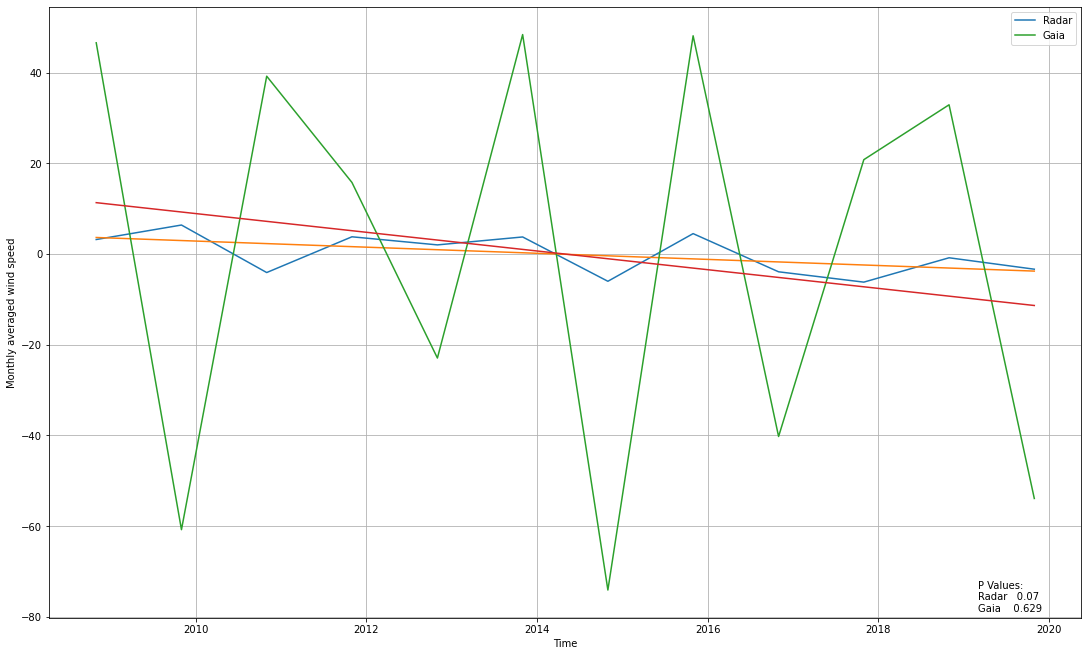

In [27]:

s = 10
e = 10
z = 106
for z in [76,80]:
    u_radar_examon = u_radar_monthly_ano.sel(time=is_mon(u_radar_monthly_ano['time.month'],s,e))
    u_gaia_examon = u_gaia_monthly_ano.sel(time=is_mon(u_gaia_monthly_ano['time.month'],s,e))

    x = np.arange(u_gaia_examon.time.shape[0])

    u_statistics_gaia = time_reg(u_gaia_examon)
    u_statistics_gaia['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
    reg_gaia = [m_gaia*i+n_gaia for i in x]

    x = np.arange(u_radar_examon.time.shape[0])
    u_statistics = time_reg(u_radar_examon)
    u_statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']

    m = (u_statistics.sel(parameter='slope',alt=[z]))
    n = (u_statistics.sel(parameter='intercept',alt=[z]))
    m_gaia = (u_statistics_gaia.sel(parameter='slope',alt=[z]))
    n_gaia = (u_statistics_gaia.sel(parameter='intercept',alt=[z]))

    reg = [m*i+n for i in x]
    

    plotstring = '\n'.join((
        r'P Values: ',
        r'Radar   '+ str(round(*u_statistics.sel(parameter='p_value',alt=[z]).values,3 )),
        r'Gaia    '+ str(round(*u_statistics_gaia.sel(parameter = 'p_value',alt=[z]).values,3 ))))
    print(plotstring)

    savestring = 'results/'+station+'_'+str(s)+'_'+str(z)+'_u.png'
    print(savestring)
    fig = plt.figure(constrained_layout=True,figsize = [15,9])

    windsel_gaia = u_gaia_examon.sel(alt = [z], method = 'nearest')
    windsel_radar = u_radar_examon.sel(alt = [z], method = 'nearest')

    ax1 = fig.add_subplot(111)
    ax1.plot(u_radar_examon.time,windsel_radar, label = 'Radar')
    ax1.plot(u_radar_examon.time,reg)
    ax1.plot(u_gaia_examon.time,windsel_gaia, label = 'Gaia')
    ax1.plot(u_gaia_examon.time,reg_gaia)

    ax1.grid()
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Monthly averaged wind speed')
    ax1.legend()
    ax1.text(.9,0.01,plotstring, transform=ax1.transAxes)
    plt.savefig(savestring)
    print('Done with z: '+str(z))

### v  

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


P Values: 
Radar   nan
Gaia    0.349
Done with z: 70


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


P Values: 
Radar   0.297
Gaia    0.632
Done with z: 80


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


P Values: 
Radar   0.4
Gaia    0.654
Done with z: 90


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


P Values: 
Radar   0.92
Gaia    0.622
Done with z: 100


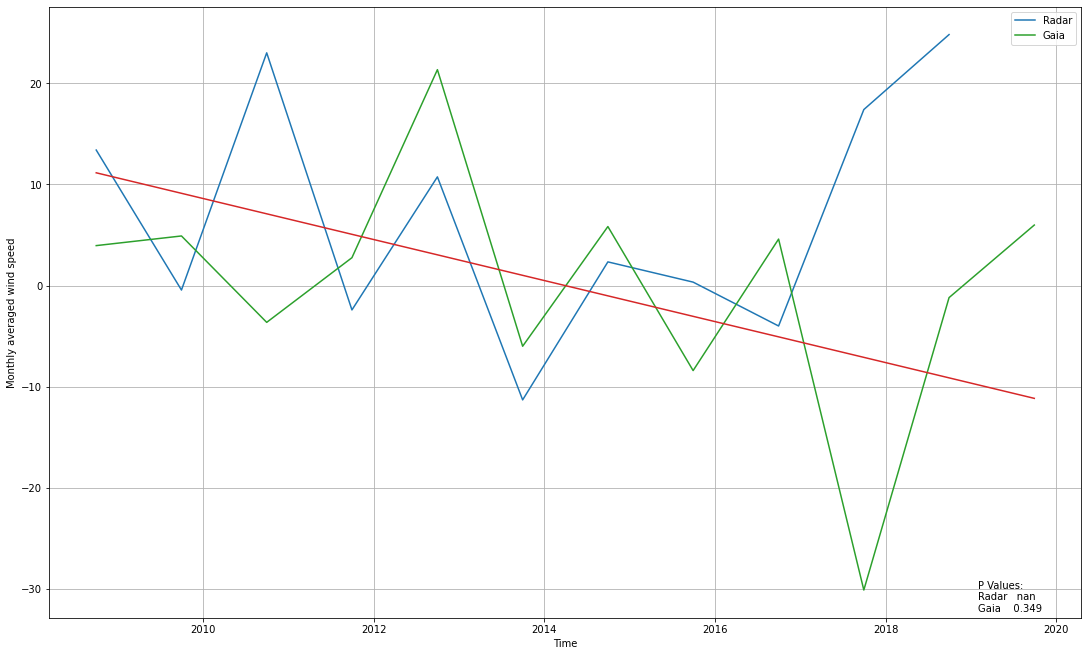

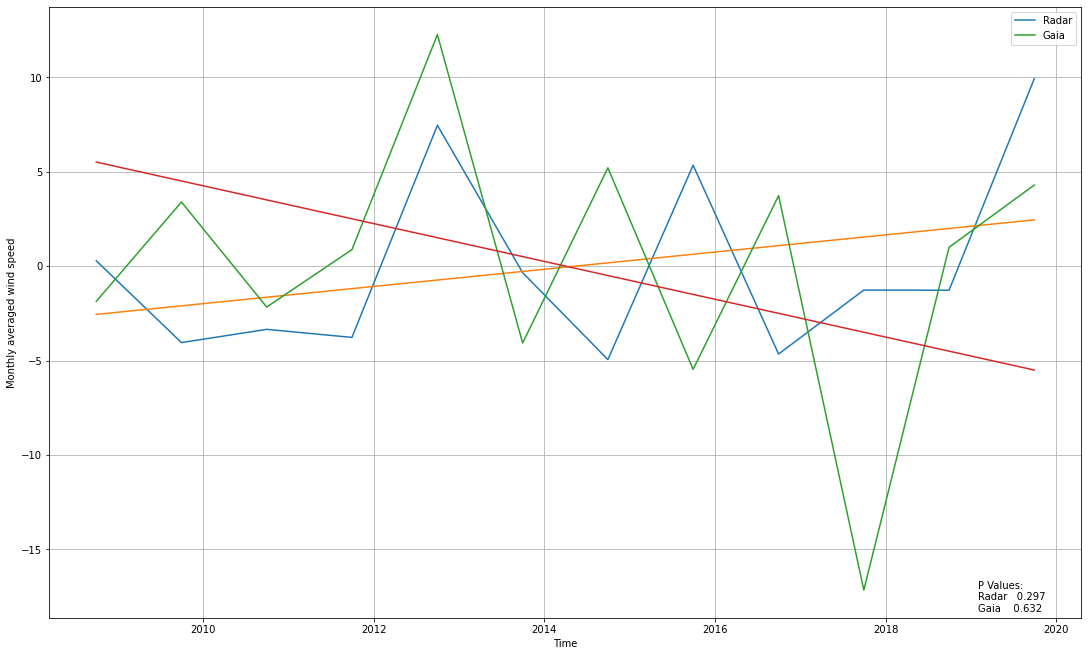

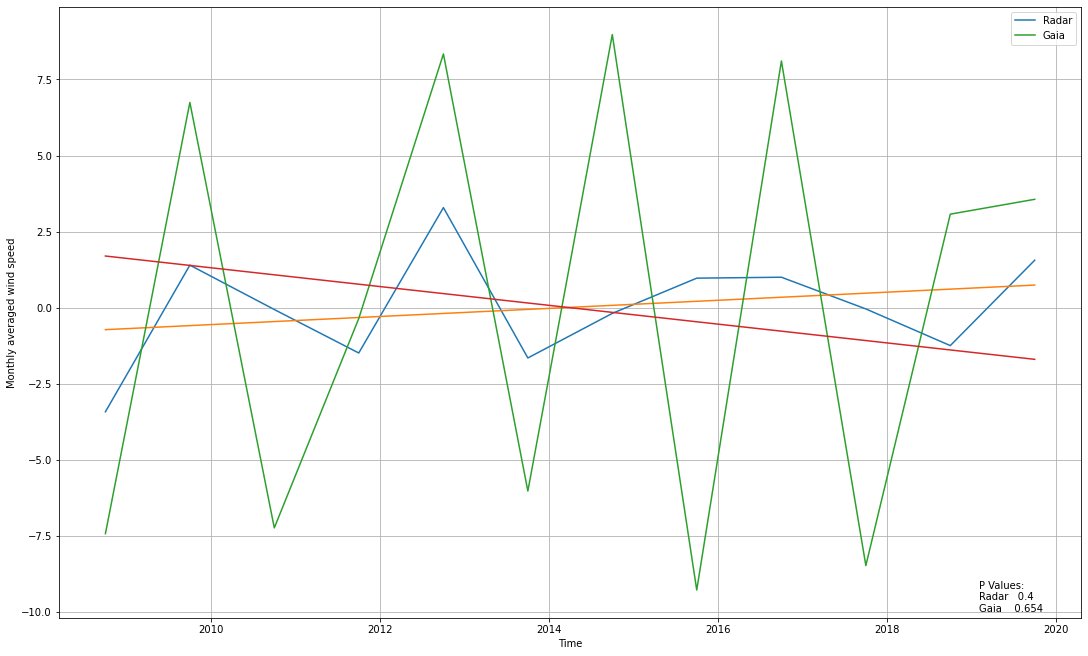

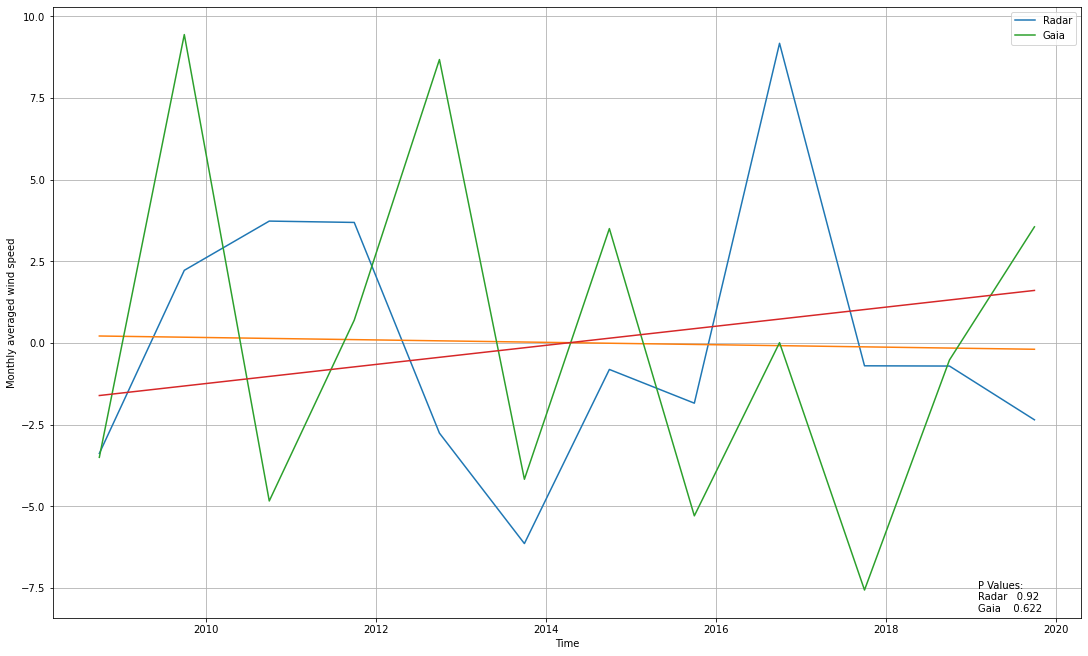

In [28]:

s = 9
e = 9
z = 106
for z in [70,80,90,100]:
    v_radar_examon = v_radar_monthly_ano.sel(time=is_mon(v_radar_monthly_ano['time.month'],s,e))
    v_gaia_examon = v_gaia_monthly_ano.sel(time=is_mon(v_gaia_monthly_ano['time.month'],s,e))

    x = np.arange(v_gaia_examon.time.shape[0])
    v_statistics_gaia = time_reg(v_gaia_examon)
    v_statistics_gaia['parameter'] = ['slope', 'intercept', 'r_valve','p_value', 'std_err']
    reg_gaia = [m_gaia*i+n_gaia for i in x]

    x = np.arange(v_radar_examon.time.shape[0])
    v_statistics = time_reg(v_radar_examon)
    v_statistics['parameter'] = ['slope', 'intercept', 'r_valve','p_value', 'std_err']

    m = (v_statistics.sel(parameter='slope',alt=[z]))
    n = (v_statistics.sel(parameter='intercept',alt=[z]))
    m_gaia = (v_statistics_gaia.sel(parameter='slope',alt=[z]))
    n_gaia = (v_statistics_gaia.sel(parameter='intercept',alt=[z]))

    reg = [m*i+n for i in x]


    plotstring = '\n'.join((
        r'P Values: ',
        r'Radar   '+ str(round(*v_statistics.sel(parameter='p_value',alt=[z]).values,3 )),
        r'Gaia    '+ str(round(*v_statistics_gaia.sel(parameter = 'p_value',alt=[z]).values,3 ))))
    print(plotstring)
    savestring = 'results/'+station+'_'+str(s)+'_'+str(z)+'_v.png'


    fig = plt.figure(constrained_layout=True,figsize = [15,9])

    windsel_gaia = v_gaia_examon.sel(alt = [z], method = 'nearest')
    windsel_radar = v_radar_examon.sel(alt = [z], method = 'nearest')

    ax1 = fig.add_subplot(111)
    ax1.plot(v_radar_examon.time,windsel_radar, label = 'Radar')
    ax1.plot(v_radar_examon.time,reg)
    ax1.plot(v_gaia_examon.time,windsel_gaia, label = 'Gaia')
    ax1.plot(v_gaia_examon.time,reg_gaia)

    ax1.grid()
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Monthly averaged wind speed')
    ax1.legend()
    ax1.text(.9,0.01,plotstring, transform=ax1.transAxes)
    plt.savefig(savestring)
    print('Done with z: '+str(z))

In [29]:
print('Done')

Done
